# Model making kitchen for gold-standard AMR examples

## Load dependencies, MIRA modeling tools, PyCIEMSS tools

In [1]:
import sympy
from copy import deepcopy as _d
from mira.metamodel import *
from mira.modeling import Model #, Author
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
import jsonschema
import itertools as itt
from tqdm.auto import tqdm
from collections import defaultdict
import requests
from sympy import IndexedBase, Indexed
from datetime import datetime

# now = datetime.now().strftime("%m-%d %H:%M")
# now

from pyciemss.PetriNetODE.interfaces_bigbox import load_and_sample_petri_model
from pyciemss.utils import get_tspan
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

## Define model and AMR sanity checks 

In [2]:
def sanity_check_tm(tm: TemplateModel):
    assert tm.templates
    all_concept_names = set(tm.get_concepts_name_map())
    all_parameter_names = set(tm.parameters)
    all_symbols = (
        all_concept_names
        | all_parameter_names
        | ({tm.time.name} if tm.time else set())
    )
    for template in tm.templates:
        assert template.rate_law
        symbols = template.rate_law.args[0].free_symbols
        for symbol in symbols:
            assert symbol.name in all_symbols, f"missing symbol: {symbol.name}"
    all_initial_names = {init.concept.name for init in tm.initials.values()}
    for concept in all_concept_names:
        assert concept in all_initial_names

# def sanity_check_amr(amr_json):
#     import requests

#     assert "schema" in amr_json
#     schema_json = requests.get(amr_json["schema"]).json()
#     jsonschema.validate(schema_json, amr_json)

## Define units

In [3]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

## Define base concepts, parameters, and initials for all models

In [4]:
MODEL_NAME = "SEIRD_base_model01"
MODEL_PATH = "../../notebook/Examples_for_TA2_Model_Representation/Working_models/"
total_population_value = 19_340_000.0
E0 = 40.0
I0 = 10.0

BASE_CONCEPTS = {
    "S": Concept(
        name="S", units=person_units(), identifiers={"ido": "0000514"}
    ),
    "E": Concept(
        name="E", units=person_units(), identifiers={"apollosv": "0000154"}
    ),
    "I": Concept(
        name="I", units=person_units(), identifiers={"ido": "0000511"}
    ),
    "R": Concept(
        name="R", units=person_units(), identifiers={"ido": "0000592"}
    ),
    "H": Concept(
        name="H", units=person_units(), identifiers={"ido": "0000511"}, 
                context={"property": "ncit:C25179"}
    ),
    "D": Concept(
        name="D", units=person_units(), identifiers={"ncit": "C28554"}
    ),
}

BASE_PARAMETERS = {
    'total_population': Parameter(name='total_population', value=total_population_value, units=person_units()),
    'beta': Parameter(name='beta', value=0.4, units=per_day_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.05,
                                                     'maximum': 0.8
                                                 })),
    'delta': Parameter(name='delta', value=0.25, units=per_day_units()),
    'gamma': Parameter(name='gamma', value=0.2, units=per_day_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.5
                                                 })),
    'death': Parameter(name='death', value=0.007, units=per_day_units(), # death rate of infectious population
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.001,
                                                     'maximum': 0.01
                                                 })),
    'hosp': Parameter(name='hosp', value=0.1, units=per_day_units(), 
                       distribution=Distribution(type='Uniform1', 
                                                 parameters={
                                                     'minimum': 0.005,
                                                     'maximum': 0.2
                                                 })),
    'los': Parameter(name='los', value=5, units=day_units()),
    'death_hosp': Parameter(name='death', value=0.07, units=per_day_units(), # death rate of hospitalized individuals
                       distribution=Distribution(type='Uniform1', 
                                                 parameters={
                                                      'minimum': 0.01,
                                                      'maximum': 0.1
                                                 }))
}

BASE_INITIALS = {
    "S": Initial(concept=Concept(name="S"), value=total_population_value - (E0 + I0)),
    "E": Initial(concept=Concept(name="E"), value=E0),
    "I": Initial(concept=Concept(name="I"), value=I0),
    "R": Initial(concept=Concept(name="R"), value=0),
    "H": Initial(concept=Concept(name="H"), value=0),
    "D": Initial(concept=Concept(name="D"), value=0),
}

observables = {}

## (1) Create base-case SEIRD model

In [5]:
S, E, I, R, D, total_population, beta, delta, gamma, death = \
    sympy.symbols('S E I R D total_population beta delta gamma death')

t1 = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta / total_population)
t2 = NaturalConversion(subject=BASE_CONCEPTS['E'],
                       outcome=BASE_CONCEPTS['I'],
                       rate_law=delta*E)
t3 = NaturalConversion(subject=BASE_CONCEPTS['I'],
                       outcome=BASE_CONCEPTS['R'],
                       rate_law=gamma*(1 - death)*I)
t4 = NaturalConversion(subject=BASE_CONCEPTS['I'],
                       outcome=BASE_CONCEPTS['D'],
                       rate_law=gamma*death*I)

In [6]:
templates = [t1, t2, t3, t4]
tm = TemplateModel(
    templates=templates,
    parameters=BASE_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name=MODEL_NAME)
)

sanity_check_tm(tm)
am = AskeNetPetriNetModel(Model(tm))
# sanity_check_amr(am.to_json())
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRD_base_model01.json


## Sample model priors, confirm that initials and parameter values are stable

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRD_base_model01.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1384061528.py:8: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


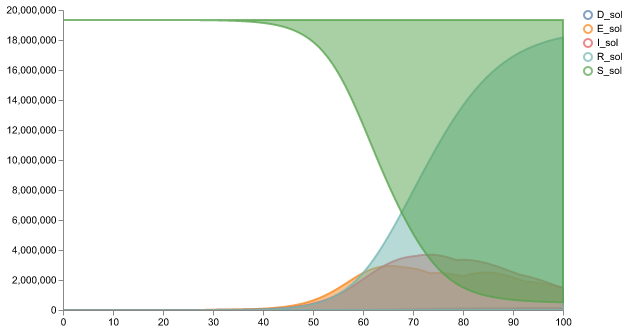

In [7]:
num_samples = 10
start_time = 0
end_time = 100
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (2) Create base-case SEIRHD model

In [9]:
MODEL_NAME = "SEIRHD_base_model01"

In [10]:
S, E, I, R, H, D, total_population, beta, delta, gamma, hosp, death_hosp, los = \
    sympy.symbols('S E I R H D total_population beta delta gamma hosp death_hosp los')

t1 = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta / total_population)
t2 = NaturalConversion(subject=BASE_CONCEPTS['E'],
                       outcome=BASE_CONCEPTS['I'],
                       rate_law=delta*E)
t3 = NaturalConversion(subject=BASE_CONCEPTS['I'],
                       outcome=BASE_CONCEPTS['R'],
                       rate_law=gamma*(1 - hosp)*I)
t4 = NaturalConversion(subject=BASE_CONCEPTS['I'],
                       outcome=BASE_CONCEPTS['H'],
                       rate_law=gamma*hosp*I)
t5 = NaturalConversion(subject=BASE_CONCEPTS['H'],
                       outcome=BASE_CONCEPTS['R'],
                       rate_law=((1 - death_hosp)/los)*H)
t6 = NaturalConversion(subject=BASE_CONCEPTS['H'],
                       outcome=BASE_CONCEPTS['D'],
                       rate_law=(death_hosp/los)*H)

In [11]:
templates = [t1, t2, t3, t4, t5, t6]
tm = TemplateModel(
    templates=templates,
    parameters=BASE_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name=MODEL_NAME)
)

sanity_check_tm(tm)
am = AskeNetPetriNetModel(Model(tm))
# sanity_check_amr(am.to_json())
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_base_model01.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_base_model01.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1858587041.py:2: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


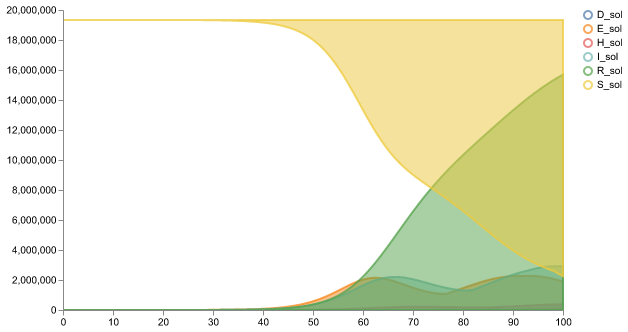

In [12]:
print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (3) Modify SEIRHD model to include reinfection (SEIRHDS)

In [13]:
MODEL_NAME = "SEIRHD_with_reinfection01"

# Add rate of immunity loss parameter
SEIRHDS_PARAMETERS = BASE_PARAMETERS
SEIRHDS_PARAMETERS["roil"] = Parameter(name='roil', value=1 / 365, units=per_day_units()) # value = 1/infectious_period

# Make sympy symbols
S, E, I, R, H, D, total_population, beta, delta, gamma, hosp, death, los, roil = \
    sympy.symbols('S E I R H D total_population beta delta gamma hosp death los roil')

# Create model template for recovered individuals returning to susceptible
t7 = NaturalConversion(subject=BASE_CONCEPTS['R'],
                       outcome=BASE_CONCEPTS['S'],
                       rate_law=roil*R)

templates = [t1, t2, t3, t4, t5, t6, t7]
tm = TemplateModel(
    templates=templates,
    parameters=SEIRHDS_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name=MODEL_NAME)
)

sanity_check_tm(tm)
am = AskeNetPetriNetModel(Model(tm))
# sanity_check_amr(am.to_json())
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_with_reinfection01.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_with_reinfection01.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1858587041.py:2: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


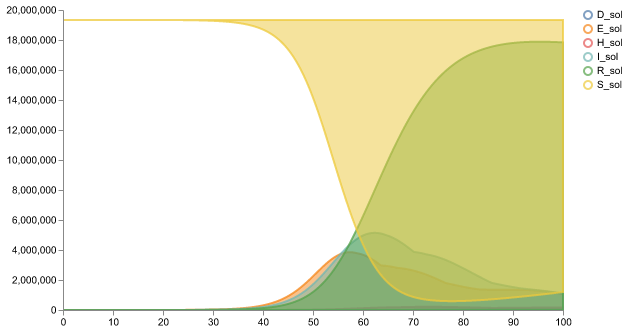

In [14]:
print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (4) Modify SEIRHD model for NPI intervention of Type 1, full compliance

In [15]:
MODEL_NAME = "SEIRHD_NPI_Type1"

# Add new parameters
SEIRHD_NPI1_PARAMETERS = BASE_PARAMETERS
SEIRHD_NPI1_PARAMETERS["kappa"] = Parameter(name='kappa', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.05,
                                                     'maximum': 0.8
                                                 }))
SEIRHD_NPI1_PARAMETERS["beta_s"] = Parameter(name='beta_s', value=1, units=per_day_units())
SEIRHD_NPI1_PARAMETERS["beta_c"] = Parameter(name='beta_c', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD_NPI1_PARAMETERS["t0"] = Parameter(name='t0', value=89, unts=day_units, units=day_units())
SEIRHD_NPI1_PARAMETERS["k"] = Parameter(name='k', value=5.0, units=dimensionless_units())

# Define new transmission template
beta_s, beta_c, t0, kappa, k, t = sympy.symbols('beta_s beta_c t0 kappa k t')
m1 = beta_c + ((beta_s - beta_c) / (1 + sympy.exp(-k*(t0 - t))))
beta_time_varying = kappa*m1

t1_npi1 = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta_time_varying / total_population)

tm_npi1 = TemplateModel(
    templates=[t1_npi1, t2, t3, t4, t5, t6],
    parameters=SEIRHD_NPI1_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='SEIRHD model NPI Type 1')
)

sanity_check_tm(tm_npi1)
am = AskeNetPetriNetModel(Model(tm_npi1))
# sanity_check_amr(am.to_json())
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_NPI_Type1.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_NPI_Type1.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1930131983.py:8: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


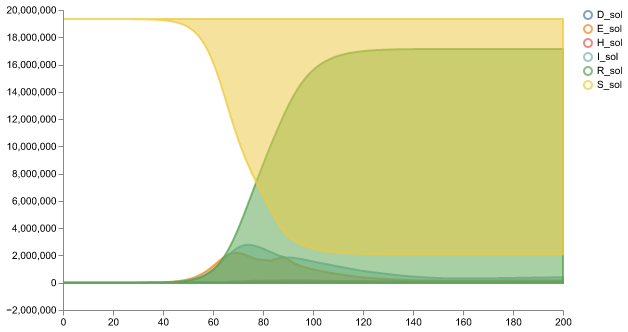

In [18]:
num_samples = 10
start_time = 0
end_time = 200
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (5) Modify SEIRHD model for NPI intervention Type 2, gradual noncompliance

In [20]:
MODEL_NAME = "SEIRHD_NPI_Type2"

SEIRHD_NPI2_PARAMETERS = SEIRHD_NPI1_PARAMETERS
SEIRHD_NPI2_PARAMETERS["beta_nc"] = Parameter(name='beta_nc', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD_NPI2_PARAMETERS["t1"] = Parameter(name='t1', value=120, unts=day_units, units=day_units()) # t1 must be greater than t0
SEIRHD_NPI2_PARAMETERS["k1"] = Parameter(name='k1', value=5.0, units=dimensionless_units())

# Define new transmission template
beta_s, beta_c, beta_nc, t0, t1, kappa, k, k1, t = sympy.symbols('beta_s beta_c beta_nc t0 t1 kappa k k1 t')
m1 = beta_nc + ((beta_s - beta_c) / (1 + sympy.exp(-k*(t0 - t)))) + ((beta_c - beta_nc) / (1 + sympy.exp(-k1*(t1 - t))))
beta_time_varying = kappa*m1

t1_npi2 = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta_time_varying / total_population)

tm_npi2 = TemplateModel(
    templates=[t1_npi2, t2, t3, t4, t5, t6],
    parameters=SEIRHD_NPI2_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='SEIRHD model NPI Type 2')
)

sanity_check_tm(tm_npi2)
am = AskeNetPetriNetModel(Model(tm_npi2))
# sanity_check_amr(am.to_json())
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_NPI_Type2.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_NPI_Type2.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1858587041.py:2: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


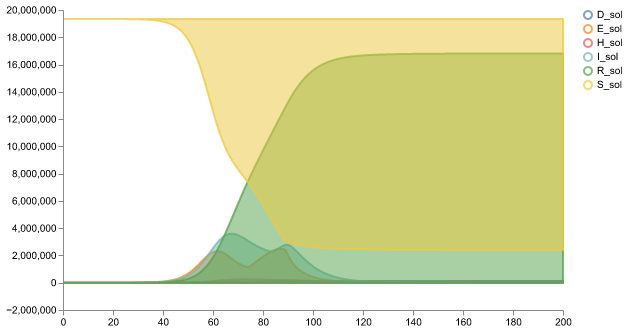

In [21]:
print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (6a) Combine these ideas to produce an SEIRHD model with a time-varying $\beta$ such that the transmission rate can smoothly change from an initial value to another value

In [23]:
MODEL_NAME = "SEIRHD_two_beta"

SEIRHD2B_PARAMETERS = BASE_PARAMETERS
SEIRHD2B_PARAMETERS["beta1"] = Parameter(name='beta1', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD2B_PARAMETERS["beta2"] = Parameter(name='beta2', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD2B_PARAMETERS["t0"] = Parameter(name='t0', value=80, unts=day_units, units=day_units())
SEIRHD2B_PARAMETERS["k"] = Parameter(name='k', value=5.0, units=dimensionless_units())

# Define new transmission template
beta1, beta2, t0, k, t = sympy.symbols('beta1 beta2 t0 k t')
beta_time_varying = beta1*(1/(1 + sympy.exp(-k*(t0 - t)))) + beta2*(1 - 1/(1 + sympy.exp(-k*(t0 - t))))

t1_2b = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta_time_varying / total_population)

tm_2b = TemplateModel(
    templates=[t1_2b, t2, t3, t4, t5, t6],
    parameters=SEIRHD2B_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='SEIRHD model with time-varying beta, beta transitions from beta1 to beta2 around t0')
)

sanity_check_tm(tm_2b)
am = AskeNetPetriNetModel(Model(tm_2b))
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_two_beta.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_two_beta.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1858587041.py:2: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


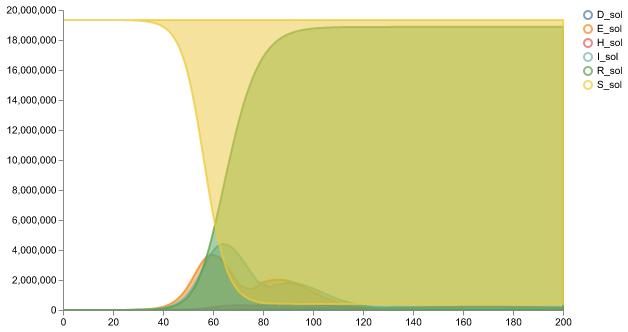

In [24]:
print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## (6b) Combine these ideas to produce a SEIRHD model with a time-varying $\beta$ such that the transmission rate can smoothly change from an initial value to another value and then a third value

In [25]:
MODEL_NAME = "SEIRHD_three_beta"

SEIRHD3B_PARAMETERS = BASE_PARAMETERS
SEIRHD3B_PARAMETERS["beta1"] = Parameter(name='beta1', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD3B_PARAMETERS["beta2"] = Parameter(name='beta2', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD3B_PARAMETERS["beta3"] = Parameter(name='beta3', value=0.4, units=per_day_units(),
                                           distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.1,
                                                     'maximum': 0.8
                                                 }))
SEIRHD3B_PARAMETERS["t0"] = Parameter(name='t0', value=80, unts=day_units, units=day_units())
SEIRHD3B_PARAMETERS["t1"] = Parameter(name='t1', value=120, unts=day_units, units=day_units()) # t1 must be greater than t0
SEIRHD3B_PARAMETERS["k"] = Parameter(name='k', value=5.0, units=dimensionless_units())

# Define new transmission template
beta1, beta2, beta3, t0, t1, k, t = sympy.symbols('beta1 beta2 beta3 t0 t1 k t')
beta_time_varying = beta1*(1/(1 + sympy.exp(-k*(t0 - t)))) + beta2*(1/(1 + sympy.exp(-k*(t1 - t))) - 1/(1 + sympy.exp(-k*(t0 - t)))) + beta3*(1 - 1/(1 + sympy.exp(-k*(t1 - t))))

t1_3b = ControlledConversion(subject=BASE_CONCEPTS['S'],
                          outcome=BASE_CONCEPTS['E'],
                          controller=BASE_CONCEPTS['I'],
                          rate_law=S*I*beta_time_varying / total_population)

tm_3b = TemplateModel(
    templates=[t1_3b, t2, t3, t4, t5, t6],
    parameters=SEIRHD3B_PARAMETERS,
    initials=BASE_INITIALS,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='SEIRHD model with time-varying beta, beta may take on up to three values: beta1, beta2, beta3')
)

sanity_check_tm(tm_3b)
am = AskeNetPetriNetModel(Model(tm_3b))
model_location = MODEL_PATH + MODEL_NAME + ".json"
print(model_location)
am.to_json_file(model_location)

../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_three_beta.json


../../notebook/Examples_for_TA2_Model_Representation/Working_models/SEIRHD_three_beta.json


/var/folders/z_/l_q4g1892pqd5g0p2z2f66_m0000gn/T/ipykernel_2143/1858587041.py:2: DeprecationWarning: 'Big Box' interfaces were a stop-gap for July 2023 hackathon.Please call the appropriate sequence from 'interfaces' insteads.
  prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,


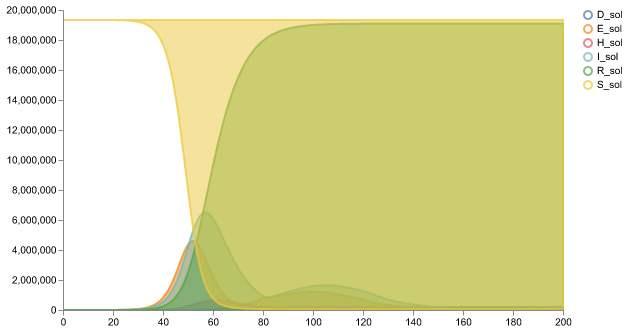

In [26]:
print(model_location)
prior_samples = load_and_sample_petri_model(model_location, num_samples, timepoints=timepoints,
                                            visual_options={"title": "Prior samples", "keep":".*_sol"}, 
                                            time_unit="days")

schema = plots.trajectories(prior_samples["data"], keep=".*_sol")
schema = plots.pad(schema, 5)
plots.ipy_display(schema)